03717357 COMP6940 A4

In [220]:
import numpy as np
import pandas as pd
from collections import OrderedDict
import re
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction import text
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.utils import shuffle
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
import nltk
# nltk.download('wordnet')
import sklearn.cluster as cluster
import time

In [3]:
corpus = ['Apple Orange Orange Apple','Apple Banana Apple Banana','Banana Apple Banana Banana Banana Apple',\
          'Banana Orange Banana Banana Orange Banana','Banana Apple Banana Banana Orange Banana']

In [4]:
''' Create a function to vectorize the counts of a list of sentences. Does not ignore case.'''
def myCountVec(corpus):
    bag = set()  # use a set to figure out how many unique words there are
    word_index = dict() # use a dict to store the column index of the word
    for line in corpus:
        for word in line.split():
            if word in bag:
                continue
            else:
                bag.add(word)
    list_of_words = sorted(list(bag)) # sort the list of words derived from set
    for index,word in enumerate(list_of_words):
        word_index[word] = index  # assign index to word
    vec_of_counts = np.zeros((len(corpus),len(word_index))) # create dummy matrix with all locations initilised to 0
    for row,line in enumerate(corpus):
        for word in line.split():
            col = word_index[word]
            vec_of_counts[row][col] += 1  # populate the matrix, increasing a word count when needed.
    return vec_of_counts

In [5]:
myCountVec(corpus)

array([[2., 0., 2.],
       [2., 2., 0.],
       [2., 4., 0.],
       [0., 4., 2.],
       [1., 4., 1.]])

In [9]:
df = pd.read_csv('MrTrumpSpeeches.csv', sep='~', encoding='latin1')
df['sentiment'] = np.where(df['like_count'] > df['dislike_count'], 1, 0)
df = shuffle(df)
df.head()

,id,playlist,upload_date,title,view_count,average_rating,like_count,dislike_count,subtitles,sentiment
404,s0m9Vi0-i5c,President Donald Trump's First 100 Days | NBC ...,20170120,Former President Barack Obamas Final Speech B...,451513.0,4.755464,6143.0,400.0,hello everybody you know Michelle we've r...,1
600,FPbEhZ1vDiU,Donald Trump Rally Speech Events Press Confere...,20161029,13 YEAR OLD GIRL Delivers THE BEST SPEECH EVER...,45400.0,4.576881,820.0,97.0,my name is faith Graham I'm a 13 year old...,1
355,l7JuPzPUEt0,President Donald Trump's First 100 Days | NBC ...,20170130,President Donald Trump Signs Latest Executive ...,25771.0,2.190840,78.0,184.0,this will be the largest ever cut by far ...,0
124,p6UJnjUoYTA,Donald Trump Speeches & Events,20160428,"FULL: Donald Trump Costa Mesa MASSIVE Rally, C...",68729.0,4.671937,929.0,83.0,we're going to have somebody who's going ...,1
570,CusqKLFApLk,Donald Trump Rally Speech Events Press Confere...,20160814,Best of Donald Trump at Fairfield Connecticut ...,2981.0,4.733333,70.0,5.0,Thank You Connecticut great people thank ...,1


In [10]:
# lets check some characteristics of the datframe
df.shape

(836, 10)

In [11]:
# ok so 836 rows by 10 columns. Lets check the numeric columns for issues
df.describe()

,upload_date,view_count,average_rating,like_count,dislike_count,sentiment
count,8.360000e+02,8.360000e+02,836.000000,836.000000,836.000000,836.000000
mean,2.016526e+07,2.478265e+04,4.345376,288.478469,56.348086,0.912679
std,4.783116e+03,6.020921e+04,0.702294,498.063763,188.722867,0.282473
min,2.016020e+07,7.100000e+01,1.347826,2.000000,0.000000,0.000000
25%,2.016081e+07,1.788000e+03,4.263935,29.000000,4.000000,1.000000
50%,2.016110e+07,8.775500e+03,4.589107,122.000000,19.000000,1.000000
75%,2.017031e+07,2.270900e+04,4.782065,358.250000,47.000000,1.000000
max,2.017080e+07,1.013054e+06,5.000000,6143.000000,3544.000000,1.000000


In [12]:
# ok so far so good. Lets check the non numeric columns
for col in ['id','playlist','title','subtitles']:
    print(df[col].describe())

count             836
unique            836
top       QU3nPqEuv5M
freq                1
Name: id, dtype: object
count                                                   836
unique                                                    5
top       Donald Trump Rally Speech Events Press Confere...
freq                                                    369
Name: playlist, dtype: object
count                                                   836
unique                                                  834
top       WATCH: President Donald Trump Press Conference...
freq                                                      2
Name: title, dtype: object
count                                                   836
unique                                                  836
top          it is our belief that by bringing   togethe...
freq                                                      1
Name: subtitles, dtype: object


In [13]:
# so looks like we have all the data. Lets check for missing data and nans
df.isnull().any()

id                False
playlist          False
upload_date       False
title             False
view_count        False
average_rating    False
like_count        False
dislike_count     False
subtitles         False
sentiment         False
dtype: bool

In [178]:
# so there are some genral punctuation marks that should be removed since they dont add anything to the context.
# Some word are enclosed inside [] indicating environment and not really contributing to the sentiment anaylysis
def cleaningFunc(line):
    #lemma = WordNetLemmatizer()
    line = re.sub('[\s]{2,}',' ',line) # replace any extra whitspace with single space
    line = re.sub('[\/\+\-,:.\$*%\&]','',line) # remove puctuation marks etc.
    line = line.lower() # convert everthing to lowercase
    words = line.split() # split into words
    newwords = []
    for word in words:
        if word.startswith('[') or word.endswith(']'): # skip words enclosed in brackets since they indicate action not sentiment or topic
            continue
        newwords.append(word)
    #return " ".join(lemma.lemmatize(word) for word in newwords) # return sentence with word seperated by a single space and lemmatized
    return " ".join(newwords)

In [179]:
df['subtitle_clean'] = df['subtitles'].apply(lambda x : cleaningFunc(x))
df.head()

,id,playlist,upload_date,title,view_count,average_rating,like_count,dislike_count,subtitles,sentiment,subtitle_clean
404,s0m9Vi0-i5c,President Donald Trump's First 100 Days | NBC ...,20170120,Former President Barack Obamas Final Speech B...,451513.0,4.755464,6143.0,400.0,hello everybody you know Michelle we've r...,1,hello everybody you know michelle we've really...
600,FPbEhZ1vDiU,Donald Trump Rally Speech Events Press Confere...,20161029,13 YEAR OLD GIRL Delivers THE BEST SPEECH EVER...,45400.0,4.576881,820.0,97.0,my name is faith Graham I'm a 13 year old...,1,my name is faith graham i'm a 13 year old girl...
355,l7JuPzPUEt0,President Donald Trump's First 100 Days | NBC ...,20170130,President Donald Trump Signs Latest Executive ...,25771.0,2.190840,78.0,184.0,this will be the largest ever cut by far ...,0,this will be the largest ever cut by far in te...
124,p6UJnjUoYTA,Donald Trump Speeches & Events,20160428,"FULL: Donald Trump Costa Mesa MASSIVE Rally, C...",68729.0,4.671937,929.0,83.0,we're going to have somebody who's going ...,1,we're going to have somebody who's going to re...
570,CusqKLFApLk,Donald Trump Rally Speech Events Press Confere...,20160814,Best of Donald Trump at Fairfield Connecticut ...,2981.0,4.733333,70.0,5.0,Thank You Connecticut great people thank ...,1,thank you connecticut great people thank you t...


For the classification tests I will be using F1 score because we are doing binary classification and this score incorporates
both false positives and false negatives in the metric.

In [187]:
# only choosing features that are >5% and <95% frequent
cvecs = CountVectorizer(min_df=2,stop_words='english',max_features=1000) 
Xcv = cvecs.fit_transform(df['subtitle_clean'].values)
print("Count matrix shape :", Xcv.shape)
tfvecs = TfidfVectorizer(min_df=2,stop_words='english',max_features=1000) 
Xtf = tfvecs.fit_transform(df['subtitle_clean'].values)
print("Tfidf matrix shape :", Xtf.shape)
# lets makes the 1 to 3 word ngram tfidf feature matrix
tfvecsngram = TfidfVectorizer(min_df=2,stop_words='english',ngram_range=(1,3),max_features=1000)
Xtfng = tfvecsngram.fit_transform(df['subtitle_clean'].values)
print("Tfidf ngram matrix shape :", Xtfng.shape)

Count matrix shape : (836, 1000)
Tfidf matrix shape : (836, 1000)
Tfidf ngram matrix shape : (836, 1000)


F1 score for test Logistic regression model on word count is 93.11%
F1 score for test Logistic regression model on TFIDF is 95.62%
F1 score for test Logistic regression model on TFIDF + ngram is 95.62%
F1 score for test Support Vector Machine model on word count is 91.74%
F1 score for test Support Vector Machine model on TFIDF is 94.9%
F1 score for test Support Vector Machine model on TFIDF + ngram is 94.9%
Tests complete


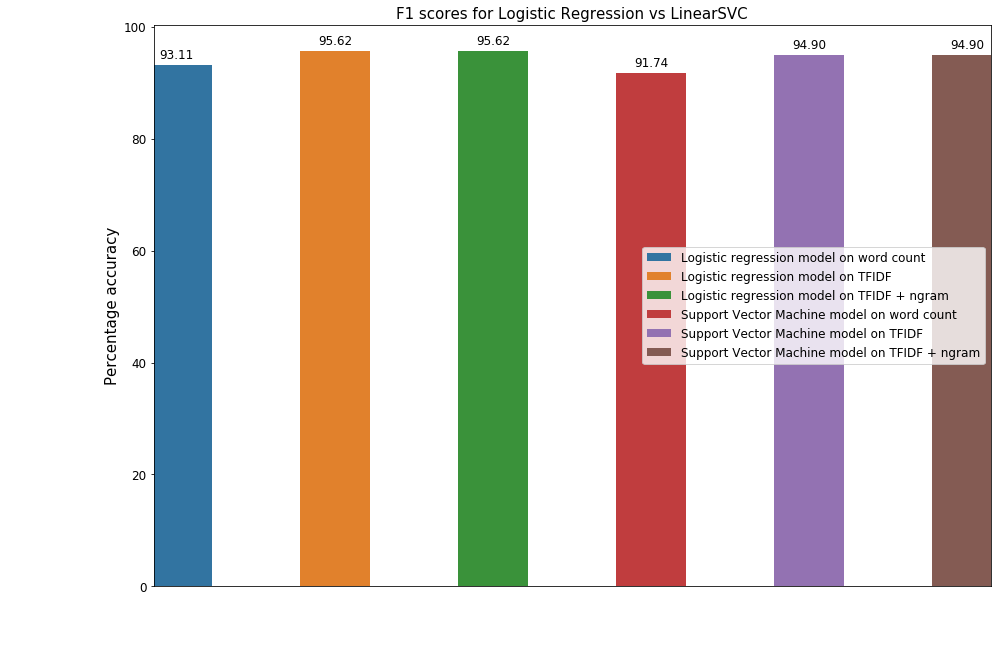

In [188]:
# lets run a loop for all the tests and store the f1 score in a list for plotting later
tests = {1:'Logistic regression model on word count',2:'Logistic regression model on TFIDF',\
         3:'Logistic regression model on TFIDF + ngram',4:'Support Vector Machine model on word count',\
         5:'Support Vector Machine model on TFIDF',6:'Support Vector Machine model on TFIDF + ngram'}
results = []
for index,dataset in enumerate([Xcv,Xtf,Xtfng]*2):
    X_train,X_test,y_train,y_test = train_test_split(dataset,df['sentiment'],test_size=0.2,random_state=1)
    if index < 3:
        logistic = LogisticRegression()
        logistic.fit(X_train,y_train)
        y_pred = logistic.predict(X_test)
        score = int(f1_score(y_test,y_pred) * 10000) / 100.0
        print("F1 score for test {} is {}%".format(tests[index+1],score))
        results.append((index+1,score))
    elif index < 6:
        support_vector = LinearSVC()
        support_vector.fit(X_train,y_train)
        y_pred = support_vector.predict(X_test)
        score = int(f1_score(y_test,y_pred) * 10000) / 100.0
        print("F1 score for test {} is {}%".format(tests[index+1],score))
        results.append((index+1,score))
    else:
        pass
print("Tests complete")
###########################################################################################
# lets plot the barplot of values
plotting_df = pd.DataFrame(list(tests.items()),columns=['index','Test'])
plotting_df['score'] = [x[1] for x in results]
fig,ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)
sns.barplot(x='index',y='score',hue='Test',data=plotting_df,ax=ax)
plt.xticks([])
plt.xlabel('') # remove xlabels
plt.ylabel('Percentage accuracy',fontsize=15)
plt.title("F1 scores for Logistic Regression vs LinearSVC",fontsize=15)
ax.legend(loc=5)
for bar in ax.patches:
    x = bar.get_x()
    width = bar.get_width()
    centre = x + width/2.
    bar.set_x(centre - 0.5/2.)
    bar.set_width(0.5)
    height = bar.get_height()
    ax.annotate("%.2f" % height, (x + width / 2., height),
             ha='center', va='center', rotation=0, xytext=(0, 10), textcoords='offset points')

## Topic Modeling (20 marks)
1. Using TFIDF and Count Vectorizer models imported for sklearn, perform topic modelling using the following topic modeling algorithms:
    1. NMF
    2. LDA
    3. SVD

2. When choosing the number of topics give a brief explanation of why that number was chosen.
3. Discuss based on the top 10 words each of the algorithms choose for each topic cluster what category the topics fall under.

In [189]:
documents = list(df['subtitle_clean']) # convert speches to list

Fitting feature matrix for K=2.....
Fitting feature matrix for K=3.....
Fitting feature matrix for K=4.....
Fitting feature matrix for K=5.....
Fitting feature matrix for K=6.....
Fitting feature matrix for K=7.....
Fitting feature matrix for K=8.....
Fitting feature matrix for K=9.....
Fitting feature matrix for K=10.....
Fitting feature matrix for K=11.....
Fitting feature matrix for K=12.....
Fitting feature matrix for K=13.....
Fitting feature matrix for K=14.....
Fitting feature matrix for K=15.....
Fitting feature matrix for K=16.....
Fitting feature matrix for K=17.....
Fitting feature matrix for K=18.....
Fitting feature matrix for K=19.....
Fitting feature matrix for K=20.....
Fitting feature matrix for K=21.....
Fitting feature matrix for K=22.....
Fitting feature matrix for K=23.....
Fitting feature matrix for K=24.....
Fitting feature matrix for K=25.....
Fitting feature matrix for K=26.....
Fitting feature matrix for K=27.....
Fitting feature matrix for K=28.....
Fitting f

Text(0.5,1,'Elbow curve')

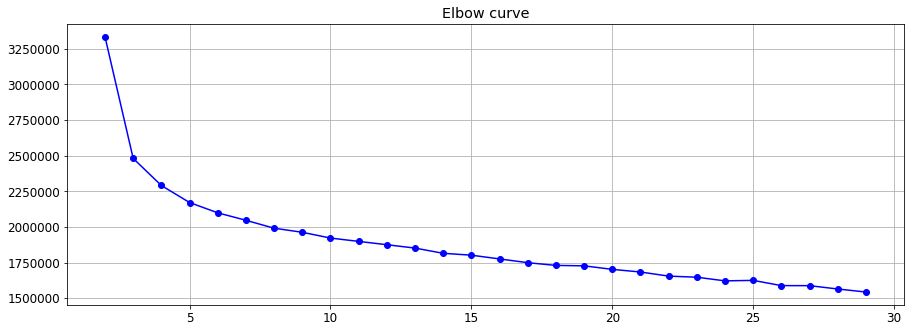

In [160]:
# lets look at the k-curve to select number of topics  
# reference : https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial
# WARNING .....takes a long time to run and is setup for 4 cores.
vectorizer = CountVectorizer(min_df=2, stop_words='english',max_features=500)
vec4k = vectorizer.fit_transform(documents)
distorsions = []
start = time.time()
for k in range(2, 30):
    print("Fitting feature matrix for K={}.....".format(k))
    kmeans = cluster.KMeans(n_clusters=k,n_jobs=4)
    kmeans.fit(vec4k)
    distorsions.append(kmeans.inertia_)
print("Elbow curve completed in {0:.2f} seconds".format(time.time()-start))
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 30), distorsions, 'bo-')
plt.grid(True)
plt.title('Elbow curve')

In [161]:
# I chose 10 topics because of "subjective" elbow point on K-Means curve above
n_topics = 10
no_top_words = 20
no_top_documents = 4

In [213]:
# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.8,min_df=2, stop_words='english',ngram_range=(1,3),max_features=500)
X4nmf = tfidf_vectorizer.fit_transform(documents)
nmf_feature_names = tfidf_vectorizer.get_feature_names()
for index,feature in enumerate(nmf_feature_names):  # replace whitespace in ngrams by - to help identify them
    if ' ' in feature:
        feature = re.sub('[\s]','-', feature)
        nmf_feature_names[index] = feature
    else:
        continue

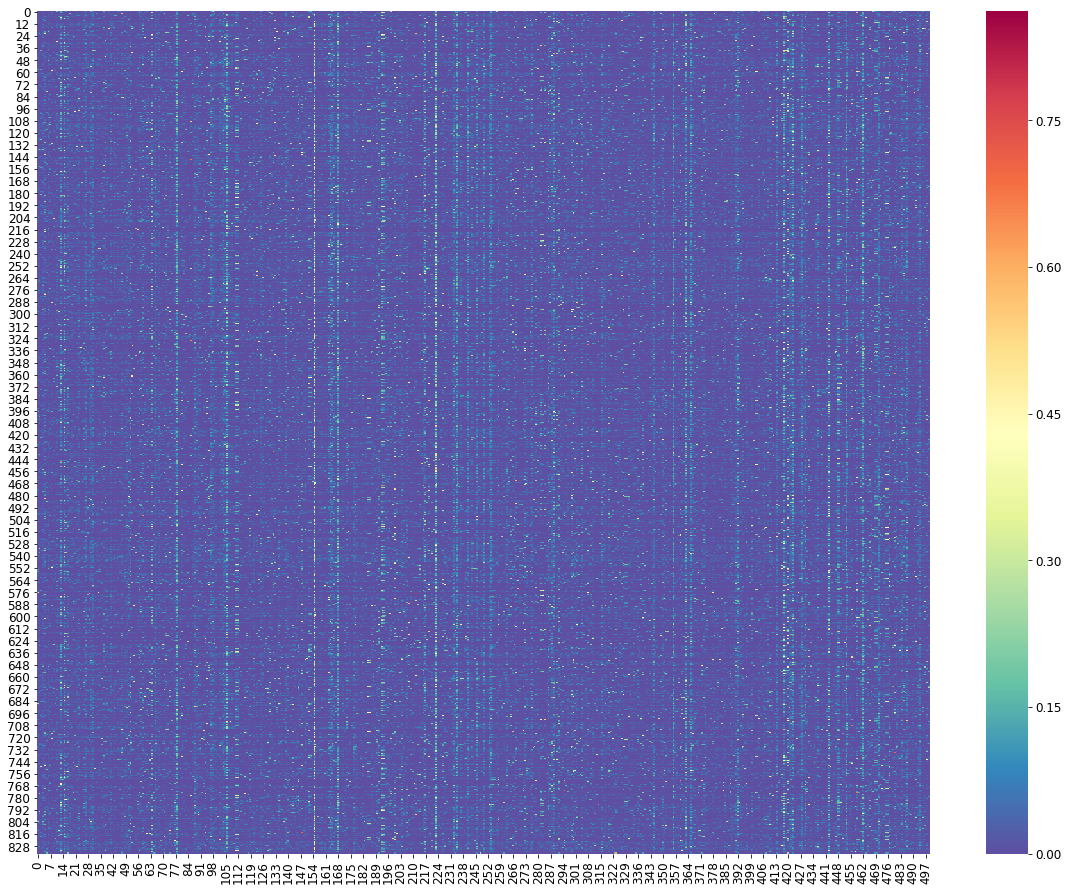

In [214]:
# lets get a sense for how sparse the matrix is
fig,ax = plt.subplots(1,1,figsize=(20,15))
sns.heatmap(X4nmf.todense(),cmap='Spectral_r',ax=ax)

In [218]:
# lets use nndsvda since faeture matrix isnt too spare
nmf_model = NMF(n_components=n_topics,random_state=1,alpha=.1,l1_ratio=.8,init='nndsvda').fit(X4nmf)
nmf_W = nmf_model.transform(X4nmf)
nmf_H = nmf_model.components_
for topic_idx, topic in enumerate(nmf_H):
    print("Topic {}:".format(topic_idx))
    print(" ".join([nmf_feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
    print("\n")
#     top_doc_indices = np.argsort( nmf_W[:,topic_idx] )[::-1][0:no_top_documents]
#     for doc_index in top_doc_indices:
#         print(documents[doc_index])

Topic 0:
know going don said like right want think great say ve ll look got lot way country good really tell


Topic 1:
american america country jobs new americans great workers make nation world future time energy today ve years god believe american-people


Topic 2:
trump donald donald-trump america know man states-america need united-states-america let president-united president-united-states tell mr-trump god family washington obama indiana party


Topic 3:
clinton hillary hillary-clinton vote country emails wants obama state change november percent jobs thank fbi isis radical department taxes africanamerican


Topic 4:
thanks watching news watch hey think order russia department general federal obama members make public vote question law north trump


Topic 5:
house white-house white trump administration russia general security morning new today national news obama think secretary press fbi department thanks


Topic 6:
health obamacare health-care care plan americans tax want hous

Category of topics:<br>
Topic 0: Donald bigging up himself<br>
Topic 1: American Jobs, American Workers<br>
Topic 2: Donald on why he is best for POTUS<br>
Topic 3: Hilary Clinton lied about emails<br>
Topic 4: Thanks for watching the news<br>
Topic 5: White House General flynn<br>
Topic 6: Helthcare and Obamacare<br>
Topic 7: Jobs,Mexico Wall, Border<br>
Topic 8: Supreme Court Judge<br>
Topic 9: Donald Thanks America.

In [254]:
# LDA is able to use tf counts
my_words = ['going']
my_stop_words = text.ENGLISH_STOP_WORDS.union(my_words)
tf4lda_vectorizer = CountVectorizer(max_df=0.7,min_df=2, stop_words=my_stop_words,max_features=1000)
tf4lda = tf4lda_vectorizer.fit_transform(documents)
lda_feature_names = tf4lda_vectorizer.get_feature_names()

In [255]:
lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=15, learning_method='batch', learning_offset=70.,\
                                      random_state=1).fit(tf4lda)
lda_W = lda_model.transform(tf4lda)
lda_H = lda_model.components_
for topic_idx, topic in enumerate(lda_H):
    print("Topic {}:".format(topic_idx))
    print(" ".join([lda_feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

Topic 0:
don america american jobs illegal vote tell hillary obamacare love united believe ll care years change got administration win americans
Topic 1:
american america jobs new clinton hillary americans energy dollars care state tax today plan work years nation job need change
Topic 2:
don win look folks ll trade okay way love got gonna wall jobs tell mexico percent hillary lot good money
Topic 3:
donald hillary got clinton don let did tell mean lot ll didn way man really okay indiana look good america
Topic 4:
don ll deal look military lot way care world good really thing china things love years countries believe iran japan
Topic 5:
united america today world american god nation day women military freedom mr work peace war security long years new honor
Topic 6:
don ll good really got love way lot okay tell guy win big did mean look let won gonna doing
Topic 7:
jobs trade united good china don new business companies ll mexico workers percent lot way tax countries years work world
To

Category of topics:<br>
Topic 0: American Jobs, Illegal Vote<br>
Topic 1: American Jobs<br>
Topic 2: Donald Wins<br>
Topic 3: Indiana<br>
Topic 4: Military(foriegn)<br>
Topic 5: Military(domestic)<br>
Topic 6: Donald Wins<br>
Topic 7: Trade<br>
Topic 8: Clinton emails<br>
Topic 9: Healthcare<br>

In [264]:
# lets use tfidf for LSA
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=2, stop_words=my_stop_words, max_features=2000)
tfidf4lsa = tfidf_vectorizer.fit_transform(documents)
lsa_feature_names = tfidf_vectorizer.get_feature_names()

In [265]:
lsa_model = TruncatedSVD(n_components=n_topics, n_iter=20 ,random_state=1).fit(tfidf4lsa)
lsa_W = lsa_model.transform(tfidf4lsa)
lsa_H = lsa_model.components_
for topic_idx, topic in enumerate(lsa_H):
    print("Topic {}:".format(topic_idx))
    print(" ".join([lsa_feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

Topic 0:
people know don great country said want like right just ve thank think say trump hillary jobs president clinton america
Topic 1:
thanks president videos exclusives highlights click clicking digital channel latest checking button interviews youtube subscribe nbc fans news trump watching
Topic 2:
american america clinton country hillary jobs thank nation americans united workers states god future bless cities world energy new families
Topic 3:
hillary clinton jobs thanks interviews country exclusives highlights clicking digital button channel checking percent latest fans nbc trade youtube subscribe
Topic 4:
trump donald hillary clinton president obama house white intelligence fbi flynn vote russian information investigation media know wants department campaign
Topic 5:
donald america trump god know hillary interviews united man clinton bless thanks nation faith states highlights exclusives clicking digital tell
Topic 6:
israel nato peace korea minister north iran terrorism prime

Category of topics:<br>
Topic 0: Trump bigging up himself<br>
Topic 1: Trump interview<br>
Topic 2: American Jobs,Workers<br>
Topic 3: Trump on Clinton interviewJobs<br>
Topic 4: General Flynn Investigation<br>
Topic 5: Donald Trump<br>
Topic 6: Foreign policy<br>
Topic 7: Trade<br>
Topic 8: Healthcare<br>
Topic 9: Acceptance speech?<br>

## Visualization (10 marks)
Choose the clusters obtained from a topic model algorithm from above and plot a word cloud for each of the clusters. 
1. For example, if the number of topics chosen was 10 and the topics were obtained from the SVD algorithm, 10 word clouds should be plotted.

In [266]:
full_doc = {}
for topic_idx, topic in enumerate(lda_H):
    top_doc_indices = np.argsort( lda_W[:,topic_idx] )[::-1][0:no_top_documents]
    tmp = ''
    for doc_index in top_doc_indices:
        tmp += df['subtitle_clean'][doc_index]
    full_doc[topic_idx] = tmp

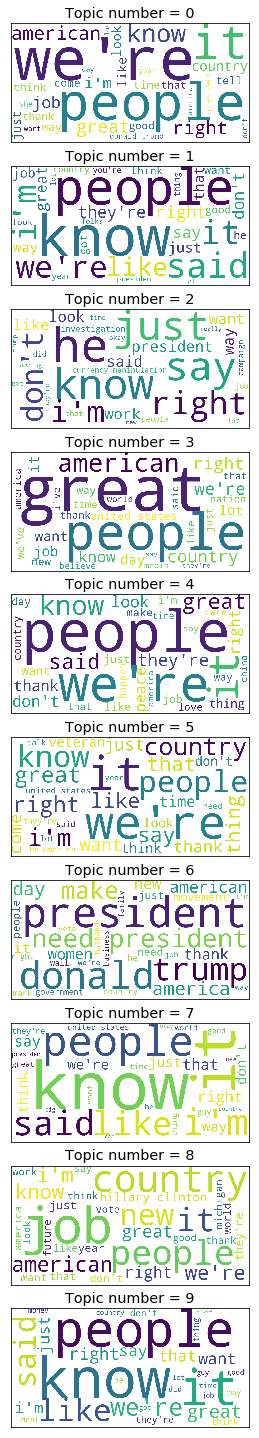

In [267]:
# lets make some wordcluds to visualize the results
plt.rcParams['font.size']=12                #10 
plt.rcParams['savefig.dpi']=100             #72 
plt.rcParams['figure.subplot.bottom']=.1 
f, axes = plt.subplots(len(full_doc),1,figsize=(25,25))
for topic in full_doc:
    text = full_doc[topic]
    wc = WordCloud(width=1000,height=500,background_color='white',max_words=30,\
                  random_state=1,stopwords=my_stop_words).generate(text)
    axes[topic].imshow(wc)
    axes[topic].set_title("Topic number = {}".format(topic))
    axes[topic].set_xticks([])
    axes[topic].set_yticks([])